# Analysis of height, weight, and sports data

### The question:
Given heights and weights of various athletes labelled with their respective sports, we would like to predict which sport they are most likely to correspond to

## My response:
I chose to complete the exercise in Python as we discussed it was your main language employed and to demonstrate that, even though I feel strongest in R, I can work in this language.

### Setup
I started by downloading the json file and establishing my workspace by importing appropriate libraries.
    
    For some reason, the json file would not open with Pandas, so I used the json library and evaluated the 
    data from there.

### Importing
The data was a dictionary with a single key holding a list of dictionaries. After selecting on the list, I converted the data into two identical Pandas DataFrame.
   
    I chose to do this after performing summary statistics overview and seeing that the data could be restructured 
    in a way that may change the outcome of prediction - conditionally setting null values to conditional means
    (i.e. E[height,weight|sport]) or dropping those observations altogether

### Data Visualization Summary
The very first thing I did was visualize the data to get a sense of what I was working with.
    
    It looked right off that weight is a great way to separate the data

### Cleaning
To clean the data, I had to address both data sets.
    
    * Renamed the 'labels' column to 'sport' - made more sense to me
    * Checked for null values - made a decision as to what to do with them
        * I replaced null value 'sport' with 'unk' (short for unknown) in the event I would later use them
    * Checked for outlier values (just visually, I did not calculate mild and extremes - i.e. IQR3-IQR1)
        * I addressed values of -1
            * Negative values for any of the categories was unreasonable and it was the only value that
            observations were valued less than or equal to zero
            * After outliers were handled:
                * One data set had the conditional mean replace null values
                * The other data set had them removed altogether
    * After performing these steps, I had balanced data for both data sets
    * I created a binary/indicator/dummy variable to indicate if the observation was soccer or not

### Model
Noting this was a classification problem ("is an observation likely to be one thing or another"), I chose to start with naive prediction and then quickly do a logistic regression
    
    * The Naive Model varied a little from the two data sets - the prediction value was only slightly higher
    for the dropped values data set for the same train-test split values
    * Logisitc regression is accurate at about the 91% level with both data sets on the same train-test split
    values
    * I'd like to try more stuff here, but the cleaning aspect took quite a bit of time and, keeping with the
    directions of only spending a few hours with it, I will only discuss what I'd like to do:
        * Cross-validation
        * KNN
        * SVM
        * Including interaction terms
        * Regularize
        * ANN - totally remove the personal model selection, use sigmoid/activation functions for selecting a good
        hypothesis function, and test on that
    


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [3]:
%matplotlib inline
# plt.show() outside of Jupyter

## Importing Data

In [77]:
import json
with open('data.json') as data_file:    
    data = json.load(data_file)
# Note: Unsure why Pandas won't read this

In [78]:
print(type(data))
# print(data)
# Note: the data is a dictionary with a single key with a list of dictionaries
#
# Get the list of dictionaries out and translate it two DataFrames as I will later use both differently
df = pd.DataFrame(data['Data'])
df2 = pd.DataFrame(data['Data'])
sns.swarmplot(x="height", y="weight",hue='label',data=df, palette="Set1")

<class 'dict'>


## Initial Cleaning


I make two data sets so as to test two methods:

    1: completely balanced based on filling missing values with conditional means
    2: null values dropped


In [79]:
print('df null values')
print(df.isnull().sum())
print()
print('df2 null values')
print(df2.isnull().sum())
print()
# Give the column a sensical name
df.rename(index=str, columns={"label": "sport"}, inplace= True)
df2.rename(index=str, columns={"label": "sport"}, inplace= True)
# Get rid of completely missing data
df.drop(df[(df['height'].isnull()) & (df['sport'].isnull()) & (df['weight'].isnull())].index, inplace=True)
df2.dropna(inplace=True)
# Define a third category of unknown to those sports with missing values
df['sport'].fillna('unk', inplace=True)
print('df null values')
print(df.isnull().sum())
print()
print('df2 null values')
print(df2.isnull().sum())
print()

print('df head')
print(df.head())
print()
print('df2 head')
print(df2.head())

df null values
height    60
label     32
weight    60
dtype: int64

df2 null values
height    60
label     32
weight    60
dtype: int64

df null values
height    33
sport      0
weight    33
dtype: int64

df2 null values
height    0
sport     0
weight    0
dtype: int64

df head
     height   sport     weight
0 -1.000000  soccer  -1.000000
1  1.778782  soccer  77.805331
3  1.918350  soccer  78.818063
4  1.707444  soccer  78.153438
5  1.474477  soccer  71.200179

df2 head
     height   sport     weight
0 -1.000000  soccer  -1.000000
1  1.778782  soccer  77.805331
3  1.918350  soccer  78.818063
4  1.707444  soccer  78.153438
5  1.474477  soccer  71.200179


##### The first data set still has some null values for height and weight where the second does not

## Descriptive Statistics

In [80]:
df.pivot_table(values = ['height', 'weight'], index = 'sport', aggfunc=['count', 'mean', 'max','min', 'std'])

count             mean                  max                min  \
           height weight    height     weight    height      weight height   
sport                                                                        
basketball    350    350  1.586792  85.923498  2.672603  111.111625   -1.0   
soccer        355    355  1.358371  65.099442  2.375724   89.711234   -1.0   
unk             5      5 -1.000000  -1.000000 -1.000000   -1.000000   -1.0   

                        std             
           weight    height     weight  
sport                                   
basketball   -1.0  1.075112  35.810567  
soccer       -1.0  1.026890  28.682530  
unk          -1.0  0.000000   0.000000

##### Note: nonsense values, min(height,weight) = -1

##### For this data set, I will replace these values with the conditional mean (i.e. E[height,weight|sport])

In [81]:
df2.pivot_table(values = ['height', 'weight'], index = 'sport', aggfunc=['count', 'mean', 'max','min', 'std'])
# Note: nonsense values, min(height,weight) = -1
# For this dataset, I will drop these rows

count             mean                  max                min  \
           height weight    height     weight    height      weight height   
sport                                                                        
basketball    350    350  1.586792  85.923498  2.672603  111.111625   -1.0   
soccer        355    355  1.358371  65.099442  2.375724   89.711234   -1.0   

                        std             
           weight    height     weight  
sport                                   
basketball   -1.0  1.075112  35.810567  
soccer       -1.0  1.026890  28.682530

### A little more cleaning

* Remove the values of -1


#### For the first data set

In [82]:
print(df[df['height']<= 0]['weight'].value_counts())
print(df[df['weight']<= 0]['weight'].value_counts())

-1.0    110
Name: weight, dtype: int64
-1.0    110
Name: weight, dtype: int64


##### Only one unique value is present in each that is nonsensical

In [84]:
df.replace(-1, np.nan, inplace=True)
print(df[df['height']<= 0]['weight'].value_counts())
print(df[df['weight']<= 0]['weight'].value_counts())

Series([], Name: weight, dtype: int64)
Series([], Name: weight, dtype: int64)


##### No minimum value is present in each that is nonsensical

In [85]:
df.pivot_table(values = ['height', 'weight'], index = 'sport', aggfunc=['count', 'mean', 'max','min', 'std'])

count             mean                   max              \
           height weight    height      weight    height      weight   
sport                                                                  
basketball    300    300  2.017924  100.410748  2.672603  111.111625   
soccer        300    300  1.790739   77.217673  2.375724   89.711234   
unk             0      0       NaN         NaN       NaN         NaN   

                 min                  std            
              height     weight    height    weight  
sport                                                
basketball  1.497770  85.004918  0.208998  4.771574  
soccer      1.326205  61.667973  0.194458  4.794592  
unk              NaN        NaN       NaN       NaN

In [86]:
print(df.isnull().sum())
df[df.isnull()]
df.head()

height    143
sport       0
weight    143
dtype: int64


,height,sport,weight
0,NaN,soccer,NaN
1,1.778782,soccer,77.805331
3,1.918350,soccer,78.818063
4,1.707444,soccer,78.153438
5,1.474477,soccer,71.200179


In [87]:
# Filling null values with some conditional values
hMeans = df.groupby('sport')['height'].mean()
wMeans = df.groupby('sport')['weight'].mean()
bMeans = [hMeans[0],wMeans[0]]
sMeans = [hMeans[1],wMeans[1]]

df.loc[(df['sport'] == 'basketball') & (df['height'].notna() == False), 'height'] = bMeans[0]
df.loc[(df['sport'] == 'basketball') & (df['weight'].notna() == False),'weight'] = bMeans[1]
df.loc[(df['sport'] == 'soccer') & (df['height'].notna() == False), 'height'] = sMeans[0]
df.loc[(df['sport'] == 'soccer') & (df['weight'].notna() == False), 'weight'] = sMeans[1]
print(df.isnull().sum())
print()
print(df[df['height'].isnull()])
print()
# Note: 5 meaningless rows

df.drop(df[df['height'].isnull()].index, inplace=True)
print(df.isnull().sum())
print()

# Setting the data for later analysis - create a binary (dummy) column
w = df['sport'] == 'soccer'
df['soccer'] = w * 1
print(df['soccer'].value_counts())

height    5
sport     0
weight    5
dtype: int64

     height sport  weight
553     NaN   unk     NaN
567     NaN   unk     NaN
644     NaN   unk     NaN
728     NaN   unk     NaN
763     NaN   unk     NaN

height    0
sport     0
weight    0
dtype: int64

1    371
0    367
Name: soccer, dtype: int64


We now have completely balanced data based on replacing NAN in sports with 'unk', replacing NAN for height and weight with the average value when the name of the sport was present (after removing values on the lower bound that didn't make sense, particularly -1), and removing rows where the data was totally null

#### For the second dataset

In [88]:
df2 = df2[(df2['height']>= 0) | (df2['weight']>= 0)]
df2.pivot_table(values = ['height', 'weight'], index = 'sport', aggfunc=['count', 'mean', 'max','min', 'std'])

count             mean                   max              \
           height weight    height      weight    height      weight   
sport                                                                  
basketball    300    300  2.017924  100.410748  2.672603  111.111625   
soccer        300    300  1.790739   77.217673  2.375724   89.711234   

                 min                  std            
              height     weight    height    weight  
sport                                                
basketball  1.497770  85.004918  0.208998  4.771574  
soccer      1.326205  61.667973  0.194458  4.794592

In [89]:
print(df2.isnull().sum())
print()

w = df2['sport'] == 'soccer'
df2['soccer'] = w * 1
print(df2['soccer'].value_counts())

height    0
sport     0
weight    0
dtype: int64

1    300
0    300
Name: soccer, dtype: int64


Both the first and the second dataset are both ready for analysis

### Back to some descriptive stats before we fit a model - First Data Set

In [90]:
df.pivot_table(values = ['height', 'weight'], index = 'sport', aggfunc=['count', 'mean', 'max','min', 'std'])

count             mean                   max              \
           height weight    height      weight    height      weight   
sport                                                                  
basketball    367    367  2.017924  100.410748  2.672603  111.111625   
soccer        371    371  1.790739   77.217673  2.375724   89.711234   

                 min                  std            
              height     weight    height    weight  
sport                                                
basketball  1.497770  85.004918  0.188902  4.312774  
soccer      1.326205  61.667973  0.174808  4.310090

In [91]:
df[['sport', 'height', 'weight']].groupby('sport').describe().transpose()

sport         basketball      soccer
height count  367.000000  371.000000
       mean     2.017924    1.790739
       std      0.188902    0.174808
       min      1.497770    1.326205
       25%      1.917316    1.697083
       50%      2.017924    1.790739
       75%      2.134373    1.896312
       max      2.672603    2.375724
weight count  367.000000  371.000000
       mean   100.410748   77.217673
       std      4.312774    4.310090
       min     85.004918   61.667973
       25%     98.046750   75.092996
       50%    100.410748   77.217673
       75%    103.148128   80.145839
       max    111.111625   89.711234

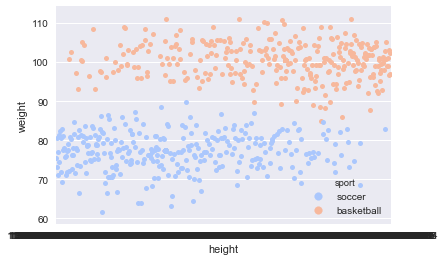

In [92]:
sns.swarmplot(x="height", y="weight",hue='sport',data=df, palette="coolwarm")

It appears weight separates the data quite nicely

In [93]:
df[['height','weight','sport']].corr(method='pearson')

,height,weight
height,1.000000,0.487134
weight,0.487134,1.000000


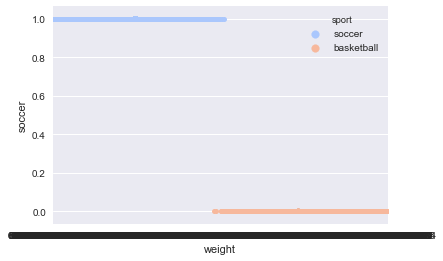

In [20]:
sns.swarmplot(x="weight", y="soccer",hue='sport',data=df, palette="coolwarm")

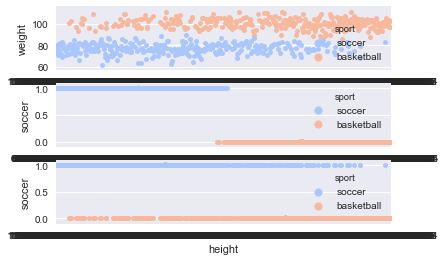

In [21]:
plt.subplot(3, 1, 1)
sns.swarmplot(x="height", y="weight",hue='sport',data=df, palette='coolwarm',size=5)
plt.subplot(3, 1, 2)
sns.swarmplot(x="weight", y="soccer",hue='sport',data=df, palette='coolwarm',size=5)
plt.subplot(3, 1, 3)
sns.swarmplot(x="height", y="soccer",hue='sport',data=df, palette='coolwarm',size=5)

It appears weight is fairly independent of height and separates the data quite nicely

## Model Fitting

SVM (rbf)

In [1]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib
from sklearn import svm

In [96]:
df3 = df
df3.head()

,height,sport,weight,soccer
0,1.790739,soccer,77.217673,1
1,1.778782,soccer,77.805331,1
3,1.918350,soccer,78.818063,1
4,1.707444,soccer,78.153438,1
5,1.474477,soccer,71.200179,1


In [98]:
# partition data (80/20)
# random_state sets seed for reproduction of results
# stratify on target (df['soccer']): ensures training set and testing set look similar
x_train, x_test, y_train, y_test = train_test_split(df3[['weight', 'height']], df3['soccer'], test_size = 0.2, random_state = 123, stratify = df3['soccer'])

In [99]:
# standardization that can be reproduced on training and testing sets by saving means 
# and standard deviations from training set standardization
scaler = preprocessing.StandardScaler().fit(x_train)
# confirm standardization
x_train_scaled = scaler.transform(x_train)
print(x_train_scaled.mean(axis = 0))
print(x_train_scaled.std(axis = 0))

[-6.80434993e-16 -7.49682802e-16]
[1. 1.]


In [100]:
# apply transformer to testing set
x_test_scaled = scaler.transform(x_test)
# confirm standardization
print(x_test_scaled.mean(axis = 0))
print(x_test_scaled.std(axis = 0))

[0.01878658 0.10081032]
[1.01084138 1.0396855 ]


In [101]:
# pipeline with preprocessing and model
pipeline = make_pipeline(preprocessing.StandardScaler(), svm.SVC())

In [102]:
# print tunable hyperparameters
print(pipeline.get_params())

{'memory': None, 'steps': [('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))], 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'svc': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'svc__C': 1.0, 'svc__cache_size': 200, 'svc__class_weight': None, 'svc__coef0': 0.0, 'svc__decision_function_shape': 'ovr', 'svc__degree': 3, 'svc__gamma': 'auto', 'svc__kernel': 'rbf', 'svc__max_iter': -1, 'svc__probability': False, 'svc__random_stat

In [103]:
# declare desired hyperparameters
hyperparameters = {"svc__kernel" : ["linear", "poly", "rbf", "sigmoid"],
                  "svc__max_iter": [50,100, 200]}

In [104]:
# tune model using cross-validation pipeline
clf = GridSearchCV(pipeline, hyperparameters, cv = 10)
# fit and tune model
clf.fit(x_train_scaled, y_train)
# print best set of parameters
print(clf.best_params_)

C:\Users\ljb14001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ljb14001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ljb14001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ljb14001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardSca

{'svc__kernel': 'rbf', 'svc__max_iter': 50}


C:\Users\ljb14001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [105]:
# refit on entire training set
print(clf.refit)

True


In [106]:
# evaluate model pipeline on test data
# predict new set of data
y_pred = clf.predict(x_test_scaled)

In [107]:
# evaluate model performance
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

1.0
0.0


In [108]:
# save model for future use
joblib.dump(clf, "svm.pkl")

['svm.pkl']

In [109]:
# to load model again
clf = joblib.load("svm.pkl")
# predict data set using loaded model
predictions = clf.predict(x_test_scaled)

In [110]:
# cross-validate
score = 0
for i in range(len(predictions)):
    if predictions[i] == y_test[i]:
        score += 1
print(score/len(predictions))

1.0


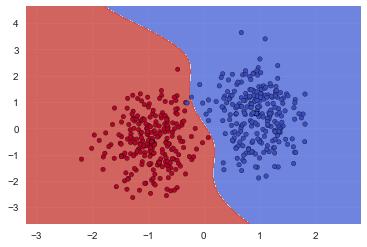

In [111]:
# decision boundary from linear SVM using principal components as measure along axes
h = 0.01
x_min, x_max = x_train_scaled[:,0].min() - 1, x_train_scaled[:,0].max() + 1
y_min, y_max = x_train_scaled[:,1].min() - 1, x_train_scaled[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx,yy,Z,cmap = plt.cm.coolwarm, alpha = 0.8)
plt.scatter(x_train_scaled[:,0], x_train_scaled[:,1], c = y_train, cmap = plt.cm.coolwarm, s = 20, edgecolors = 'k')
plt.show()

(60/40) split for SVM (linear)

In [113]:
# partition data (60/40)
# random_state sets seed for reproduction of results
# stratify on target (df['sport']): ensures training set and testing set look similar
x_train1, x_test1, y_train1, y_test1 = train_test_split(df3[['weight', 'height']], df3['soccer'], test_size = 0.4, random_state = 123, stratify = df3['soccer'])

In [115]:
# standardization that can be reproduced on training and testing sets by saving means 
# and standard deviations from training set standardization
scaler = preprocessing.StandardScaler().fit(x_train1)
# confirm standardization
x_train_scaled1 = scaler.transform(x_train1)
print(x_train_scaled1.mean(axis = 0))
print(x_train_scaled1.std(axis = 0))

[ 4.40070303e-16 -5.18438987e-16]
[1. 1.]


In [116]:
# apply transformer to testing set
x_test_scaled1 = scaler.transform(x_test1)
# confirm standardization
print(x_test_scaled1.mean(axis = 0))
print(x_test_scaled1.std(axis = 0))

[0.00155636 0.04509763]
[1.00189317 1.0257095 ]


In [118]:
# pipeline with preprocessing and model
pipeline1 = make_pipeline(preprocessing.StandardScaler(), svm.SVC())

In [120]:
# print tunable hyperparameters
print(pipeline1.get_params())

{'memory': None, 'steps': [('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))], 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'svc': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'svc__C': 1.0, 'svc__cache_size': 200, 'svc__class_weight': None, 'svc__coef0': 0.0, 'svc__decision_function_shape': 'ovr', 'svc__degree': 3, 'svc__gamma': 'auto', 'svc__kernel': 'rbf', 'svc__max_iter': -1, 'svc__probability': False, 'svc__random_stat

In [121]:
# declare desired hyperparameters
hyperparameters = {"svc__kernel" : ["linear", "poly", "rbf", "sigmoid"],
                  "svc__max_iter": [50, 100, 200]}

In [122]:
# tune model using cross-validation pipeline
clf1 = GridSearchCV(pipeline, hyperparameters, cv = 10)
# fit and tune model
clf1.fit(x_train_scaled1, y_train1)
# print best set of parameters
print(clf1.best_params_)

C:\Users\ljb14001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ljb14001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ljb14001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\ljb14001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardSca

{'svc__kernel': 'linear', 'svc__max_iter': 50}


In [123]:
# refit on entire training set
print(clf1.refit)

True


In [124]:
# evaluate model pipeline on test data
# predict new set of data
y_pred1 = clf1.predict(x_test_scaled1)

In [125]:
# evaluate model performance
print(r2_score(y_test1, y_pred1))
print(mean_squared_error(y_test1, y_pred1))

0.9864858695155915
0.0033783783783783786


In [126]:
# save model for future use
joblib.dump(clf1, "svm1.pkl")

['svm1.pkl']

In [127]:
# to load model again
clf = joblib.load("svm1.pkl")
# predict data set using loaded model
predictions1 = clf1.predict(x_test_scaled1)

In [128]:
# cross-validate
score = 0
for i in range(len(predictions1)):
    if predictions1[i] == y_test1[i]:
        score += 1
print(score/len(predictions1))

0.9966216216216216


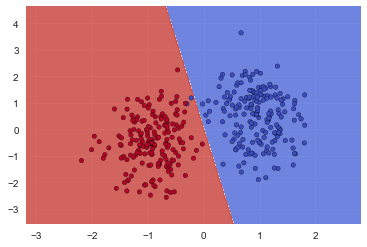

In [129]:
# decision boundary from linear SVM
h1 = 0.01
x_min1, x_max1 = x_train_scaled1[:,0].min() - 1, x_train_scaled1[:,0].max() + 1
y_min1, y_max1 = x_train_scaled1[:,1].min() - 1, x_train_scaled1[:,1].max() + 1
xx1, yy1 = np.meshgrid(np.arange(x_min1, x_max1, h1), np.arange(y_min1, y_max1, h1))
Z1 = clf1.predict(np.c_[xx1.ravel(), yy1.ravel()])
Z1 = Z1.reshape(xx1.shape)
plt.contourf(xx1,yy1,Z1,cmap = plt.cm.coolwarm, alpha = 0.8)
plt.scatter(x_train_scaled1[:,0], x_train_scaled1[:,1], c = y_train1, cmap = plt.cm.coolwarm, s = 20, edgecolors = 'k')
plt.show()